# Parâmetros do experimento

In [1]:
DATA_PATH = 'data/motionsense.csv'
LOG_PATH = 'evaluation/minirocket/'

In [2]:
FEATURES = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
SEED = 2024
K = 10

In [3]:
# pontos sao problematicos
FEATURES = [feat.replace('.', '_') for feat in FEATURES]

# Carregando os dados processados

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv(DATA_PATH, index_col=0)

In [6]:
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,trial
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,0.0,0.0,1.0
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,0.0,0.0,1.0
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,0.0,0.0,1.0
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,0.0,0.0,1.0
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,0.0,0.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1412865 entries, 0 to 1412864
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   attitude.roll       1412865 non-null  float64
 1   attitude.pitch      1412865 non-null  float64
 2   attitude.yaw        1412865 non-null  float64
 3   gravity.x           1412865 non-null  float64
 4   gravity.y           1412865 non-null  float64
 5   gravity.z           1412865 non-null  float64
 6   rotationRate.x      1412865 non-null  float64
 7   rotationRate.y      1412865 non-null  float64
 8   rotationRate.z      1412865 non-null  float64
 9   userAcceleration.x  1412865 non-null  float64
 10  userAcceleration.y  1412865 non-null  float64
 11  userAcceleration.z  1412865 non-null  float64
 12  act                 1412865 non-null  float64
 13  id                  1412865 non-null  float64
 14  trial               1412865 non-null  float64
dtypes: float64(15)
memor

In [8]:
df['act'].nunique() # lembrar de mapear id para string da classe

6

# Separando pares X e y

In [9]:
import numpy as np

In [10]:
df['act'].unique()

array([0., 1., 2., 3., 4., 5.])

In [11]:
subject_id = 1
act_id = 0
subject_mask = df['id'] == subject_id
act_mask = df['act'] == act_id

X = []
y = []

for label in df['act'].unique():
  for subj_id in df['id'].unique():
    subj_mask = df['id'] == subj_id
    act_mask = df['act'] == label
    filtered_df = df[subj_mask & act_mask].reset_index()

    X.append(
        np.stack(
            [
              filtered_df['userAcceleration.x'].values,
              filtered_df['userAcceleration.y'].values,
              filtered_df['userAcceleration.z'].values
            ]
        )
    )
    y.append(label)

In [12]:
y = np.array(y)

In [13]:
n_labels = np.unique(y).shape[0]
n_labels

6

# Extraindo features usando o MiniRocket

Inpirado no [tutorial](https://www.aeon-toolkit.org/en/stable/examples/transformations/minirocket.html#MiniRocket). Rocket requer que as séries tenham o mesmo tamanho (comprimento). Então, fazemos [padding](https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.transformations.collection.pad.PaddingTransformer.html) com zeros.



In [14]:
from aeon.transformations.collection.convolution_based import MiniRocket, Rocket
from aeon.transformations.collection import PaddingTransformer

/home/kenzosaki/miniconda3/envs/ts/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
/home/kenzosaki/miniconda3/envs/ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [15]:
univar_X_processed = []
for channel in range(len(FEATURES)):
  print(f'- Processing channel {channel}: {FEATURES[channel]}.')
  X_curr = [np.expand_dims(example[channel], axis=0) for example in X]
  transformer = PaddingTransformer() # é necessário que todas as séries tenham o mesmo tamanho
  minirocket = MiniRocket(num_kernels=10_000, n_jobs=5, random_state=SEED)  # por padrao, MiniRocket usa ~10_000 kernels
  X_padded = transformer.fit_transform(X_curr)
  X_features = minirocket.fit_transform(X_padded)
  univar_X_processed.append(X_features)

- Processing channel 0: userAcceleration_x.
- Processing channel 1: userAcceleration_y.
- Processing channel 2: userAcceleration_z.


In [16]:
transformer = PaddingTransformer()
minirocket = MiniRocket(num_kernels=10_000, n_jobs=5, random_state=SEED)

X_padded = transformer.fit_transform(X)
multivar_X_processed = minirocket.fit_transform(X_padded)

In [17]:
univar_X_processed[0].shape

(144, 9996)

In [18]:
multivar_X_processed.shape

(144, 9996)

# Avaliando um classificador simples

In [19]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
import json

In [20]:
def evaluate_simple_classifier(X: np.array, y: np.array, k: int = 5, verbose: bool = False) -> dict[str, list[int]]:

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)

    folds_accuracy = []
    folds_f1 = []

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index] # n da para ter um np array com dimensoes diferentes :(
        y_train, y_test = y[train_index], y[test_index]

        clf = RidgeClassifier()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')

        folds_accuracy.append(acc)
        folds_f1.append(f1)

        if verbose:
            print(f"- Fold {i + 1} full report")
            print(classification_report(y_test, y_pred))
    
    return {'accuracy': folds_accuracy, 'macro_f1': folds_f1}

In [21]:
# cenário univariado
for i, X_processed in enumerate(univar_X_processed):
    print(f'Univariate channel {i} - {FEATURES[i]}')
    metrics = evaluate_simple_classifier(univar_X_processed[i], y, k=K)
    print(f"\t- mean accuracy: {np.mean(metrics['accuracy']):.3f} +/- {np.std(metrics['accuracy']):.3f}")
    print(f"\t- mean f1: {np.mean(metrics['macro_f1']):.3f} +/- {np.std(metrics['macro_f1']):.3f}")
    
    with open(f'{LOG_PATH}univariate_{FEATURES[i]}.json', 'w') as f:
        json.dump(metrics, f, indent=4)

Univariate channel 0 - userAcceleration_x
	- mean accuracy: 0.811 +/- 0.083
	- mean f1: 0.798 +/- 0.086
Univariate channel 1 - userAcceleration_y
	- mean accuracy: 0.868 +/- 0.060
	- mean f1: 0.850 +/- 0.085
Univariate channel 2 - userAcceleration_z
	- mean accuracy: 0.846 +/- 0.045
	- mean f1: 0.822 +/- 0.056


In [22]:
# cenário multivariado
print(f'Multi-variate')
metrics = evaluate_simple_classifier(multivar_X_processed, y, k=K)
print(f"\t- mean accuracy: {np.mean(metrics['accuracy']):.3f} +/- {np.std(metrics['accuracy']):.3f}")
print(f"\t- mean f1: {np.mean(metrics['macro_f1']):.3f} +/- {np.std(metrics['macro_f1']):.3f}")

with open(f'{LOG_PATH}multivar.json', 'w') as f:
    json.dump(metrics, f, indent=4)

Multi-variate
	- mean accuracy: 0.881 +/- 0.055
	- mean f1: 0.872 +/- 0.062


# Gerando uma matriz de confusão

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [24]:
LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]

In [25]:
# gerando um holdout simples para a última avaliação
X_train, X_test, y_train, y_test = train_test_split(multivar_X_processed, y, test_size=0.2, random_state=SEED, stratify=y)

In [26]:
model = RidgeClassifier()
model.fit(X_train, y_train)

RidgeClassifier()

In [27]:
preds = model.predict(X_test)

In [28]:
y_test

array([0., 0., 5., 1., 3., 3., 3., 2., 4., 1., 4., 5., 0., 1., 5., 0., 2.,
       5., 3., 2., 3., 1., 5., 4., 0., 1., 2., 4., 2.])

In [29]:
print(classification_report(y_test, preds, target_names=LABELS))

              precision    recall  f1-score   support

         dws       0.83      1.00      0.91         5
         ups       1.00      0.80      0.89         5
         wlk       1.00      1.00      1.00         5
         jog       1.00      1.00      1.00         5
         std       0.80      1.00      0.89         4
         sit       1.00      0.80      0.89         5

    accuracy                           0.93        29
   macro avg       0.94      0.93      0.93        29
weighted avg       0.94      0.93      0.93        29



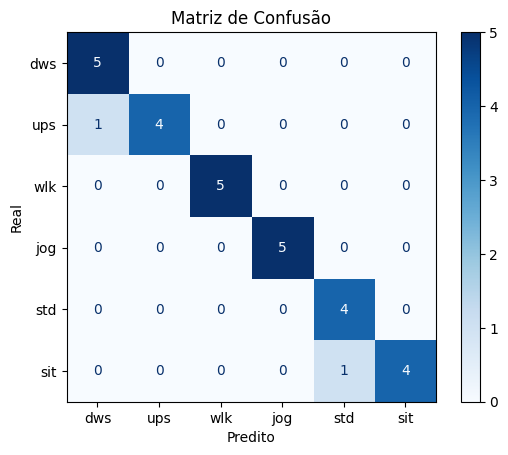

In [30]:
# gerando matriz de confusão
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap=plt.cm.Blues,)
disp.ax_.set_title('Matriz de Confusão')
disp.ax_.set_xlabel('Predito')
disp.ax_.set_ylabel('Real')
plt.savefig('data/figures/minirocket_conf_mat.pdf', bbox_inches='tight')